# 0 Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import torchvision.models as models
import string
import nltk
nltk.download('punkt_tab')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


[nltk_data] Downloading package punkt_tab to /home/white/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1 Dataset

In [2]:
captions_file = '../data/train/captions_train.txt'

captions_df = pd.read_table(captions_file, delimiter=',', header=None, names=['image', 'caption'])

captions_df.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## 1.1 Dataframe

In [3]:
# Get only unique images
unique_images = captions_df['image'].unique()


# Split images
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)


# DataFrame creation
train_df = captions_df[captions_df['image'].isin(train_images)].reset_index(drop=True)
train_df = train_df.dropna().reset_index(drop=True)
val_df = captions_df[captions_df['image'].isin(val_images)].reset_index(drop=True)
val_df = val_df.dropna().reset_index(drop=True)
test_df = captions_df[captions_df['image'].isin(test_images)].reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)

print(f"Numero di immagini nel set di addestramento: {len(train_images)}")
print(f"Numero di immagini nel set di validazione: {len(val_images)}")
print(f"Numero di immagini nel set di test: {len(test_images)}")

Numero di immagini nel set di addestramento: 16018
Numero di immagini nel set di validazione: 1780
Numero di immagini nel set di test: 4450


## 1.2 Vocabulary class

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_freq = {}
        self.idx = 4
        # self.translator = str.maketrans("","", string.punctuation + string.digits + "\t\r\n")
         

    def __len__(self):
        return len(self.word2idx)

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text)

    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                if word not in self.word_freq:
                    self.word_freq[word] = 1
                else:
                    self.word_freq[word] += 1

                if self.word_freq[word] == self.freq_threshold:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in tokenized_text]

In [5]:
vocab = Vocabulary(freq_threshold=5)
caption_list = train_df['caption'].tolist()
vocab.build_vocabulary(caption_list)

print(f"Dimensione del vocabolario: {len(vocab)}")

Dimensione del vocabolario: 5900


## 1.3 Glove

In [6]:
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Caricati {len(embeddings)} vettori di embedding da GloVe.")
    return embeddings

# Caricamento degli embeddings GloVe
glove_file = '../glove/glove.6B.100d.txt'  # Sostituisci con il percorso corretto
glove_embeddings = load_glove_embeddings(glove_file)

def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Inizializza con un vettore casuale per le parole non trovate
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 100  # Deve corrispondere alla dimensione degli embeddings GloVe scaricati
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)

Caricati 400000 vettori di embedding da GloVe.


## 1.4 Dataset class

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        # Creiamo una lista di coppie (immagine, didascalia)
        self.image_ids = []
        self.captions = []

        grouped = dataframe.groupby('image')['caption'].apply(list).reset_index()

        for idx in range(len(grouped)):
            img_id = grouped.loc[idx, 'image']
            captions = grouped.loc[idx, 'caption']
            for cap in captions:
                self.image_ids.append(img_id)
                self.captions.append(cap)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.word2idx['<START>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.word2idx['<END>'])
        numericalized_caption = torch.tensor(numericalized_caption)

        return image, numericalized_caption

### 1.4.1 Transformation Sequence

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Valori standard per ImageNet
        std=[0.229, 0.224, 0.225]
    ),
])

tranf_only_tensor = transforms.Compose([
    transforms.ToTensor()
])

## 1.5 Dataset creation

In [9]:
image_dir = '../data/train'

train_dataset = FlickrDataset(train_df, image_dir, vocab, transform=transform)
val_dataset = FlickrDataset(val_df, image_dir, vocab, transform=transform)
test_dataset = FlickrDataset(test_df, image_dir, vocab, transform=transform)
test_dataset_or = FlickrDataset(test_df, image_dir, vocab, transform=tranf_only_tensor)

In [10]:
def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    images = torch.stack(images, dim=0)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])
    return images, captions

In [11]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# 2 Model

## 2.1 Attention layer

In [12]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: [batch_size, num_pixels, encoder_dim]
        # decoder_hidden: [batch_size, decoder_dim]
        
        att1 = self.encoder_att(encoder_out)      # [batch_size, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden)   # [batch_size, attention_dim]
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # [batch_size, num_pixels]
        alpha = self.softmax(att)                 # weigths attention [batch_size, num_pixels]
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # [batch_size, encoder_dim]
        
        return context, alpha

## 2.1 Encoder (ResNet50 and Attention)

In [13]:
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Congeliamo i parametri dell'encoder
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        # Estraiamo le feature map
        features = self.resnet(images)  # [batch_size, 2048, feature_map_size, feature_map_size]
        features = features.permute(0, 2, 3, 1)    # [batch_size, feature_map_size, feature_map_size, 2048]
        features = features.view(features.size(0), -1, features.size(-1))  # [batch_size, num_pixels, 2048]
        return features  # Restituisce le feature map spaziali

## 2.2 Decoder (LSTM)

In [14]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_size, hidden_size, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, hidden_size, attention_dim)  # attention module

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.decode_step = nn.LSTMCell(embed_size + encoder_dim, hidden_size, bias=True) 
        self.init_h = nn.Linear(encoder_dim, hidden_size) 
        self.init_c = nn.Linear(encoder_dim, hidden_size)
        self.f_beta = nn.Linear(hidden_size, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=self.dropout)

    def forward(self, encoder_out, captions):
        """
        encoder_out: [batch_size, num_pixels, encoder_dim]
        captions: [batch_size, max_caption_length]
        """
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        vocab_size = self.vocab_size

        # Inizializza LSTM state
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # [batch_size, hidden_size]
        c = self.init_c(mean_encoder_out)

        # Rimuove il token di stop
        embeddings = self.embedding(captions)  # [batch_size, max_caption_length, embed_size]

        # Per salvare le predizioni
        predictions = torch.zeros(batch_size, captions.size(1), vocab_size).to(device)

        for t in range(captions.size(1)):
            batch_size_t = sum([l > t for l in [captions.size(1)]*batch_size])
            context, _ = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # Gate di attenzione
            context = gate * context

            # Concatenazione dell'embedding e del contesto
            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1)
            h, c = self.decode_step(lstm_input, (h[:batch_size_t], c[:batch_size_t]))  # LSTM step

            preds = self.fc(self.dropout(h))  # [batch_size_t, vocab_size]
            predictions[:batch_size_t, t, :] = preds

        return predictions

    def sample(self, encoder_out, max_len=20):
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)

        # Inizializza LSTM state
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)

        # Inizializza la didascalia generata
        sampled_ids = []
        inputs = self.embedding(torch.tensor([vocab.word2idx['<START>']]).to(device))  # [1, embed_size]

        for _ in range(max_len):
            context, alpha = self.attention(encoder_out, h)

            gate = self.sigmoid(self.f_beta(h))  # Gate di attenzione
            context = gate * context

            lstm_input = torch.cat([inputs.squeeze(0), context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))

            preds = self.fc(self.dropout(h))  # [vocab_size]
            predicted = preds.argmax(dim=1)   # [1]
            sampled_ids.append(predicted.item())

            if predicted.item() == vocab.word2idx['<END>']:
                break

            inputs = self.embedding(predicted)  # [1, embed_size]

        return sampled_ids

In [15]:
attention_dim = 256
embed_size = 100
hidden_size = 512
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, vocab_size).to(device)

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 3 Training

In [16]:
learning_rate = 3e-4

for param in decoder.embedding.parameters():
    param.requires_grad = False

learning_rate = 1e-3

## 3.1 Training function

In [17]:
def train_model(encoder, decoder, criterion, decoder_optimizer, dataloader, valdataloader, num_epochs):
    encoder.train()
    decoder.train()

    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):

        # training phase
        for i, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)

            decoder_optimizer.zero_grad()

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            targets = captions[:, 1:].reshape(-1)  # target shift
            outputs = outputs.view(-1, outputs.size(-1))
            loss = criterion(outputs, targets)
            train_losses.append(loss.item())

            # Backward pass e optim
            loss.backward()
            decoder_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        # validation phase
        for i, (images, captions) in enumerate(valdataloader):
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            targets = captions[:, 1:].reshape(-1)  # target shift
            outputs = outputs.view(-1, outputs.size(-1))
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())


    return train_losses, val_losses

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/10], Step [0/2503], Loss: 8.6954
Epoch [1/10], Step [100/2503], Loss: 4.9339
Epoch [1/10], Step [200/2503], Loss: 4.6420
Epoch [1/10], Step [300/2503], Loss: 4.0970
Epoch [1/10], Step [400/2503], Loss: 3.9571
Epoch [1/10], Step [500/2503], Loss: 4.0034
Epoch [1/10], Step [600/2503], Loss: 3.8118
Epoch [1/10], Step [700/2503], Loss: 3.9554
Epoch [1/10], Step [800/2503], Loss: 3.8024
Epoch [1/10], Step [900/2503], Loss: 4.1681
Epoch [1/10], Step [1000/2503], Loss: 3.7694
Epoch [1/10], Step [1100/2503], Loss: 3.5494
Epoch [1/10], Step [1200/2503], Loss: 3.6710
Epoch [1/10], Step [1300/2503], Loss: 3.9949
Epoch [1/10], Step [1400/2503], Loss: 3.4635
Epoch [1/10], Step [1500/2503], Loss: 3.2756
Epoch [1/10], Step [1600/2503], Loss: 3.3479
Epoch [1/10], Step [1700/2503], Loss: 3.6986
Epoch [1/10], Step [1800/2503], Loss: 3.6373
Epoch [1/10], Step [1900/2503], Loss: 3.8181
Epoch [1/10], Step [2000/2503], Loss: 3.2213
Epoch [1/10], Step [2100/2503], Loss: 3.6663
Epoch [1/10], Step [22

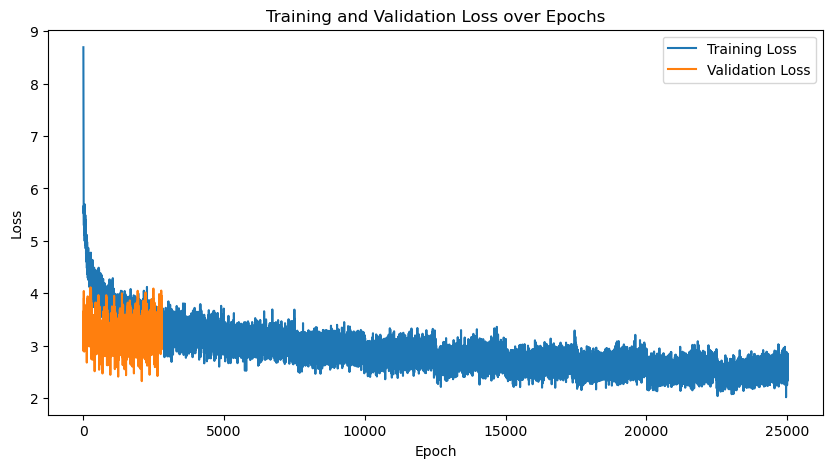

In [35]:
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)
# train_losses, val_losses = train_model(
    # encoder, decoder, criterion, optimizer, train_loader, val_loader, num_epochs
# )

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 Caption generation and testing

In [18]:
def generate_caption(encoder, decoder, image, vocab, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Preprocessamento dell'immagine
        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # Aggiunge la dimensione batch se necessario
        image = image.to(device)

        # Ottieni le feature dall'encoder
        encoder_out = encoder(image)  # [batch_size=1, num_pixels, encoder_dim]

        # Inizializza lo stato nascosto dell'LSTM
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # [1, num_pixels, encoder_dim]
        num_pixels = encoder_out.size(1)

        # Inizializza gli stati h e c dell'LSTM
        mean_encoder_out = encoder_out.mean(dim=1)  # [1, encoder_dim]
        h = decoder.init_h(mean_encoder_out)        # [1, decoder_dim]
        c = decoder.init_c(mean_encoder_out)

        # Inizializza la didascalia generata e l'input
        sampled_ids = []
        inputs = torch.tensor([vocab.word2idx['<START>']]).to(device)
        inputs = decoder.embedding(inputs)  # [1, embed_size]

        for _ in range(max_length):
            # Calcola il contesto e i pesi di attenzione
            context, alpha = decoder.attention(encoder_out, h)  # context: [1, encoder_dim]

            # Gate di attenzione
            gate = decoder.sigmoid(decoder.f_beta(h))  # [1, encoder_dim]
            context = gate * context

            # Concatenazione dell'input e del contesto
            lstm_input = torch.cat([inputs, context], dim=1)  # [1, embed_size + encoder_dim]

            # Aggiornamento dello stato dell'LSTM
            h, c = decoder.decode_step(lstm_input, (h, c))  # h, c: [1, hidden_size]

            # Predizione della prossima parola
            outputs = decoder.fc(decoder.dropout(h))  # [1, vocab_size]
            _, predicted = outputs.max(1)             # predicted: [1]

            predicted_id = predicted.item()
            sampled_ids.append(predicted_id)

            # Se il token predetto è <END>, termina la generazione
            if predicted_id == vocab.word2idx['<END>']:
                break

            # Prepara l'input per il prossimo passo
            inputs = decoder.embedding(predicted)  # [1, embed_size]

        # Converti gli indici in parole
        sampled_caption = [vocab.idx2word[word_id] for word_id in sampled_ids]
        sentence = ' '.join(sampled_caption)

    return sentence

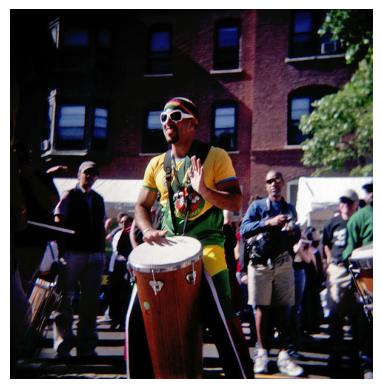

Didascalia Generata: A man in a red shirt plays a drum in a public square . <END>


In [28]:
import random

# image picking
idx = random.randint(0, len(test_dataset))
test_image, _ = test_dataset[idx]
print_image, _ = test_dataset_or[idx]
plt.imshow(print_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# caption generation
caption = generate_caption(encoder, decoder, test_image, vocab)
print("Didascalia Generata:", caption)

## 4.1 Plot losses

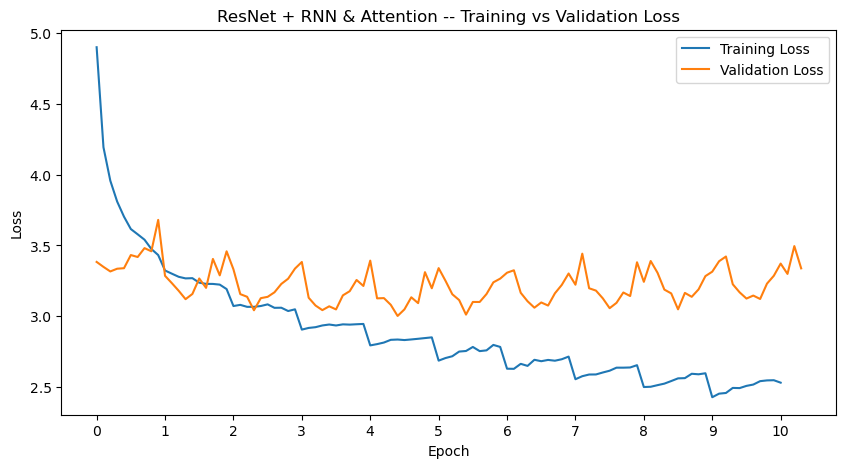

In [60]:
def mean(l): return sum(l)/len(l)

lt = len(train_losses)
lv = len(val_losses)
step = 100
t_l = [mean(train_losses[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
v_l = [mean(val_losses[i:min(i+lv//step, lv)]) for i in range(0, lv, lv//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.plot(v_l, label='Validation Loss')
plt.title('ResNet + RNN & Attention -- Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), 10), labels=range(0, 11))
plt.legend()
# plt.show()
plt.savefig('../img/resnet_rnn_att.pdf', format='pdf')

# 5 Chekpoint

In [19]:
# save model
# torch.save(
#     {
#         "encoder_state_dict": encoder.state_dict(),
#         "decoder_state_dict": decoder.state_dict(),
#         "train_losses": train_losses,
#         "val_losses": val_losses,
#     },
#     "../ckpt/resnet_rnn_att.ckpt",
# )

checkpoint = torch.load("../ckpt/resnet_rnn_att.ckpt")

encoder = EncoderCNN(embed_size)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder = encoder.to(device)

decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, vocab_size).to(device)
decoder.load_state_dict(checkpoint["decoder_state_dict"])
decoder = decoder.to(device)

train_losses = checkpoint["train_losses"]
val_losses = checkpoint["val_losses"]